#### What is nltk ?
##### -> stands for Natural Langauge Toolkit
##### -> Programs for symbolic and statistical natural langauge processing (NLP)
##### -> Lexical Analysis : Word and Text tokenizer
##### -> Tree model and text chunker for capturing

In [1]:
#import necessary libraries
import re
import nltk
import numpy as np
import networkx as nx
from typing import List, Sequence
from __future__ import annotations
from nltk.corpus import stopwords
from nltk.cluster.util import cosine_distance
from nltk.tokenize import sent_tokenize, word_tokenize

In [2]:
"""NLTK (Natural Language Toolkit) provides tokenizers and stopword lists that we’ll need later for breaking down text into words/sentences and 
filtering out common words like “the, and, is”. This function checks if these resources are available, and downloads them if missing. 
This prevents runtime errors later in the notebook."""
def _ensure_nltk():
    try:
        nltk.data.find("tokenizers/punkt")
    except LookupError:
        nltk.download("punkt", quiet=True)
    try:
        nltk.data.find("tokenizers/punkt_tab")
    except LookupError:
        nltk.download("punkt_tab", quiet=True)
    try:
        nltk.data.find("corpora/stopwords")
    except LookupError:
        nltk.download("stopwords", quiet=True)

#### Normalize the senteneces

In [3]:
"""Lowercases, strips non-alphabetic tokens, and tokenizes a sentence. Returns a list of tokens (words)."""
def _normalize_sentence(sentence: str):
    tokens = word_tokenize(sentence.lower())
    return [re.sub(r"[^a-z]", "", t) for t in tokens if re.sub(r"[^a-z]", "", t)]

#### Compute sentence_similarity 

In [4]:
"""This function is used to compute cosine similarity between two sentences represented as word-count vectors."""
def _sentence_similarity(s1_tokens: Sequence[str], s2_tokens: Sequence[str], stop_words: set[str]) -> float:
    # Remove stop words
    s1 = [w for w in s1_tokens if w not in stop_words]
    s2 = [w for w in s2_tokens if w not in stop_words]
    # Handle empty sentences
    if not s1 or not s2:
        return 0.0
        
    all_words = list(set(s1 + s2))
    # Build frequency vectors
    v1 = np.array([s1.count(w) for w in all_words], dtype=float)
    v2 = np.array([s2.count(w) for w in all_words], dtype=float)

    # Cosine distance -> convert to similarity
    dist = cosine_distance(v1, v2)
    if np.isnan(dist):
        return 0.0
    return 1.0 - float(dist)  # return the similarity value

#### generate similarity matrix

In [5]:
"""Build an NxN similarity matrix for N sentences."""
def _build_similarity_matrix(sentences_tokens: List[List[str]], stop_words: set[str]) -> np.ndarray:
    n = len(sentences_tokens)
    sim_mat = np.zeros((n, n), dtype=float)
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            sim_mat[i, j] = _sentence_similarity(sentences_tokens[i], sentences_tokens[j], stop_words)
    return sim_mat

#### Anti-redundancy logic & lambda tuning

In [6]:
# Keeps sentences informative and non-duplicate.
def mmr_rank(indices, sentences, sim_mat, top_n, lambda_=0.75):
    selected = []
    candidates = list(indices)  # high→low by PR already
    while candidates and len(selected) < top_n:
        if not selected:
            selected.append(candidates.pop(0))
            continue
        # pick candidate that maximizes: lambda*relevance - (1-lambda)*max_similarity_to_selected
        best, best_score = None, -1e9
        for c in candidates:
            rel = 1.0  # already ranked by PR; treat as equal after ordering
            red = max(sim_mat[c, s] for s in selected) if selected else 0.0
            score = lambda_ * rel - (1 - lambda_) * red
            if score > best_score:
                best_score, best = score, c
        selected.append(best)
        candidates.remove(best)
    selected.sort()
    return selected


In [7]:
"""Summarize text by extracting the top_n most important sentences using TextRank.
Args:text: The full input text (one or more paragraphs), top_n: Number of sentences to return in the summary, language: Stopword language for NLTK.
Returns: A list of `top_n` sentences in their original order of appearance."""
def summarize(text: str, top_n: int, language: str = "english") -> List[str]:
    
    if not isinstance(text, str) or not text.strip():
        return []
        
    _ensure_nltk()
    # Split into sentences (preserve originals for final ordering)
    sentences = [s.strip() for s in sent_tokenize(text) if s.strip()]
    if len(sentences) <= top_n:
        return sentences  # nothing to summarize

    # Tokenize & normalize each sentence
    sentences_tokens = [_normalize_sentence(s) for s in sentences]

    # Stopwords
    stop_words = set(stopwords.words(language))

    # Similarity matrix + PageRank
    sim_mat = _build_similarity_matrix(sentences_tokens, stop_words)
    graph = nx.from_numpy_array(sim_mat)
    scores = nx.pagerank(graph)

    # Rank sentences by score (desc), then keep the best `top_n`. Maintain original document order in the final output
    ranked_indices = sorted(scores, key=scores.get, reverse=True)[:top_n]
    ranked_indices = mmr_rank(ranked_indices, sentences, sim_mat, top_n=top_n, lambda_=0.75)
    ranked_indices.sort()  # restore original order
    summary_sentences = [sentences[i] for i in ranked_indices]
    return summary_sentences,sentences, graph, scores, ranked_indices, sim_mat

#### Read files

In [8]:
import os
from docx import Document
import PyPDF2

def read_file(path, encoding="utf-8"):
    """
    Reads text from different file types (.txt, .docx, .pdf).
    Extendable to more formats if needed.
    """
    ext = os.path.splitext(path)[1].lower()
    
    if ext == ".txt":
        with open(path, "r", encoding=encoding, errors="ignore") as f:
            return f.read()
    
    elif ext == ".docx":
        doc = Document(path)
        return "\n".join([para.text for para in doc.paragraphs if para.text.strip()])
    
    elif ext == ".pdf":
        text = ""
        with open(path, "rb") as f:
            reader = PyPDF2.PdfReader(f)
            for page in reader.pages:
                text += page.extract_text() + "\n"
        return text
    
    else:
        raise ValueError(f"Unsupported file type: {ext}")

#### Generate summary

In [9]:
 def summarize_from_file(path, top_n=None, language="english"):
    try:
        top_n = int(input("Enter the number of sentences for the summary: "))
    except ValueError:
        print("Invalid input, defaulting to 3 sentences.")
        top_n = 3
    text = read_file(path)
    return text, summarize(text, top_n=top_n, language=language)

In [10]:
#Display summary
(text, results) = summarize_from_file("C:/Users/swami/Documents/Sem3Course/IndependentStudy/Project Proposal - Independent Study.docx", 3)
summary,sentences, graph, scores, ranked_ind, sim_mat = results
print("\n".join(summary))

Enter the number of sentences for the summary:  5


Project Proposal
Customer Behavior and Engagement Analysis Using Machine Learning and NLP
This project aims to analyze customer interactions and engagement patterns across digital platforms.
Machine learning models will be applied to segment customers, predict engagement trends, and identify key factors influencing consumer behavior.
Research & Literature Review – Investigate existing work in customer behavior analytics, NLP techniques for business applications, and the latest trends in customer segmentation and engagement modeling.
NLP Analysis – Perform sentiment analysis, topic modeling, and named entity recognition to uncover customer opinions and key themes.
Meetings
Mentor–Student Meetings:
Frequency: weekly (every two weeks)
Format: 1-hour virtual or in-person
Total Meetings: 10–12 over the course of the project
Required Readings & Assignments
Assessment & Grading Criteria
100-Word Work Plan
Over the term, the student will research, design, and implement a customer behavior and 

#### Visualize the network of ranked sentences

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def plot_summary_graph_pretty(
    graph: nx.Graph,
    scores: dict[int, float],
    sentences: list[str],         
    ranked_indices: list[int],
    sim_mat: np.ndarray | None,
    edge_keep: float = 0.75,
    node_size_scale: float = 4500.0,
    seed: int = 42,
):
    # layout
    pos = nx.spring_layout(graph, seed=seed, k=0.8/np.sqrt(max(1, graph.number_of_nodes())))

    # PR → size & color
    pr = np.array([scores[n] for n in graph.nodes])
    pr_min, pr_max = pr.min(), pr.max()
    pr_norm = (pr - pr_min) / (pr_max - pr_min + 1e-12)
    node_sizes = (0.3 + 0.7*pr_norm) * node_size_scale
    cmap = mpl.cm.viridis
    node_colors = cmap(pr_norm)

    # edges
    edges = []
    for u, v, d in graph.edges(data=True):
        w = d.get("weight", (sim_mat[u, v] if sim_mat is not None else 1.0))
        edges.append((u, v, float(w)))

    if edge_keep < 1.0 and edges:
        keep = set()
        by_node = {}
        for u, v, w in edges:
            by_node.setdefault(u, []).append((u, v, w))
            by_node.setdefault(v, []).append((v, u, w))
        for n, lst in by_node.items():
            lst.sort(key=lambda t: t[2], reverse=True)
            k = max(1, int(len(lst) * edge_keep))
            keep.update((min(a,b), max(a,b)) for (a,b,_) in lst[:k])
        edges = [(u, v, w) for (u, v, w) in edges if (min(u,v), max(u,v)) in keep]

    if edges:
        weights = np.array([w for _,_,w in edges])
        wmin, wmax = weights.min(), weights.max()
        wnorm = (weights - wmin) / (wmax - wmin + 1e-12)
        widths = 0.5 + 3.0*wnorm
        alphas = 0.25 + 0.55*wnorm
    else:
        widths = alphas = []

    # ---- create fig/ax and attach colorbar to ax ----
    fig, ax = plt.subplots(figsize=(10, 8))

    for (u, v, w), width, alpha in zip(edges, widths, alphas):
        nx.draw_networkx_edges(graph, pos, edgelist=[(u, v)],
                               width=width, alpha=alpha, edge_color="gray", ax=ax)

    nx.draw_networkx_nodes(graph, pos, node_size=node_sizes, node_color=node_colors,
                           linewidths=0.5, edgecolors="black", ax=ax)
    nx.draw_networkx_labels(graph, pos, labels={i: str(i) for i in graph.nodes},
                            font_size=9, font_weight="bold", ax=ax)

    if ranked_indices:
        nx.draw_networkx_nodes(
            graph, pos, nodelist=ranked_indices,
            node_size=[node_sizes[list(graph.nodes).index(i)] for i in ranked_indices],
            node_color="none", edgecolors="red", linewidths=2.2, ax=ax
        )

    sm = mpl.cm.ScalarMappable(cmap=cmap, norm=mpl.colors.Normalize(vmin=pr_min, vmax=pr_max))
    sm.set_array([])
    fig.colorbar(sm, ax=ax, shrink=0.8, pad=0.02, label="PageRank score")  # <-- key line

    ax.set_title("Sentence Similarity Graph\n(size & color = PageRank; red outline = selected summary)")
    ax.set_axis_off()
    fig.tight_layout()
    plt.show()

    # quick legend table in console
    print("Index → sentence (first 80 chars)")
    for i, s in enumerate(sentences):
        mark = " *" if i in ranked_indices else "  "
        print(f"{i:>2}{mark}  {s[:80]}{'…' if len(s) > 80 else ''}")


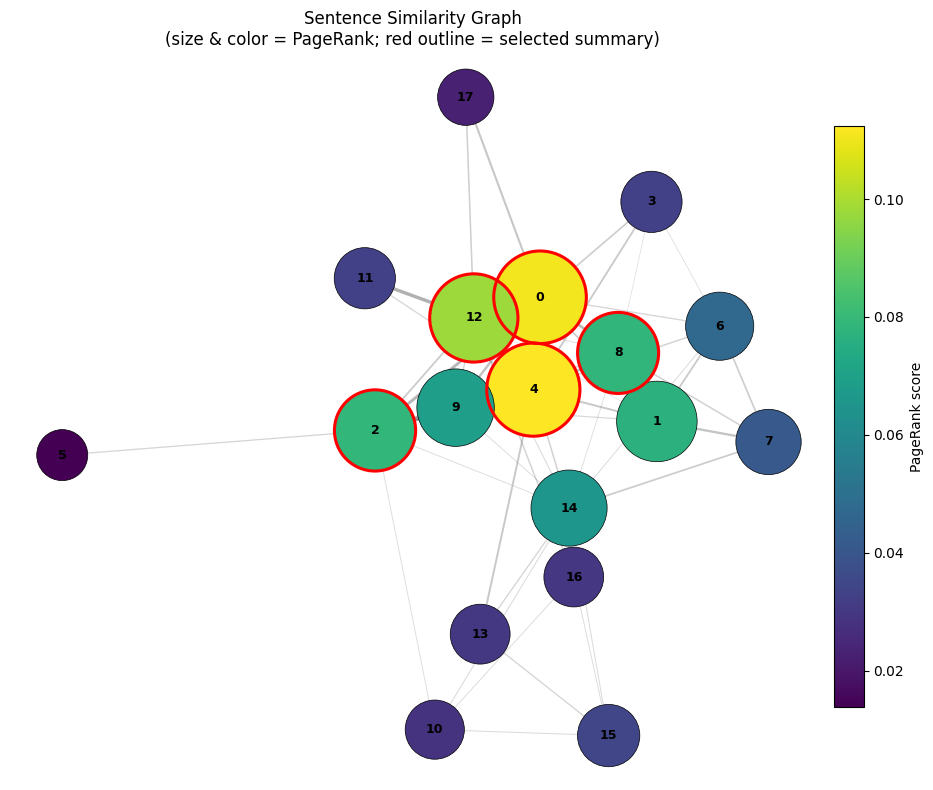

Index → sentence (first 80 chars)
 0 *  Project Proposal
Customer Behavior and Engagement Analysis Using Machine Learnin…
 1    The solution will involve collecting and preprocessing multimodal data, using na…
 2 *  Machine learning models will be applied to segment customers, predict engagement…
 3    The outcomes will be used to visualize behavioral patterns, enabling business st…
 4 *  Research & Literature Review – Investigate existing work in customer behavior an…
 5    Identify gaps and opportunities for innovation in current approaches.
 6    Data Collection – Gather multimodal datasets from customer reviews, social media…
 7    Data Preprocessing – Clean and prepare textual and other data formats for analys…
 8 *  NLP Analysis – Perform sentiment analysis, topic modeling, and named entity reco…
 9    Machine Learning Modeling – Apply clustering, classification, and predictive mod…
10    Evaluation & Optimization – Assess model performance, validate results, and refi…
11    Work

In [12]:
plot_summary_graph_pretty(graph, scores, sentences, ranked_ind, sim_mat)

#### Simple summary statistics

In [14]:
def summary_stats(text, summary_sentences):
    orig_len = len(text.split())
    summ_len = sum(len(s.split()) for s in summary_sentences)
    return {
        "sentences_in_doc": text.count(".") + text.count("!") + text.count("?"),
        "summary_sentences": len(summary_sentences),
        "orig_words": orig_len,
        "summary_words": summ_len,
        "compression_ratio": round(orig_len / max(1, summ_len), 2)
    }

# after summarizing:
print(summary_stats(text, summary))


{'sentences_in_doc': 20, 'summary_sentences': 5, 'orig_words': 380, 'summary_words': 145, 'compression_ratio': 2.62}
